## How can we do forecasting in an environment of uncertainty?

[![Logo][fanchart]][fanchartURL]

1. This was one of questions brought up as a topic during a long overdue course on systems engineering I'm currently attending @ work.
2. We were introduced to monte carlo simulations in excel (not for betting in casinos). It is basically a tool to guage the outcome/payout/projections with randomisations to input parameters over large multiple runs >1000 .
3. I'm curious to the effects of the selection of probability distributions on such outcomes.
4. This will also be useful for my own notes on machine learning where sample data is fitted into a unknown assumed population distribution.
4. There is a also recently released opensource Forecasting tool from facebook - Prophet that could be adapted for forcasting purposes, we shall benchmark against it.
5. As I have studied changi airport previously , I will continue to base this experiment on forcasting the monthly air passenger arrivals in Changi.
6. Partly because aggregated monthly data since year 1961 is freely avaliable from data.gov.sg 
7. Welcome all views below in the comments section

[fanchart]: https://upload.wikimedia.org/wikipedia/commons/8/83/FanChartInfl.jpg "Hypothetical Fan Chart of the Inflation Rate"
[fanchartURL]: https://en.wikipedia.org/wiki/Fan_chart_(time_series)

In [1]:
%matplotlib inline

from scripts.wykeith import pulldatagov,plotexpdata

from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
datauid = "93b737b7-1f4d-4250-868a-11d1d649c12a"
df = pulldatagov(datauid)
df.head()

,month,no_of_air_passenger_arrivals
_id,,
1,1961-01-01,11814
2,1961-02-01,11027
3,1961-03-01,12703
4,1961-04-01,13159
5,1961-05-01,12221


In [3]:
mthrange=20*12
noofruns=1000
seed=2017

dates_list = df.as_matrix(['month']).flatten()
date_start = dates_list[0]
date_end = dates_list[-1] + relativedelta(months=mthrange)

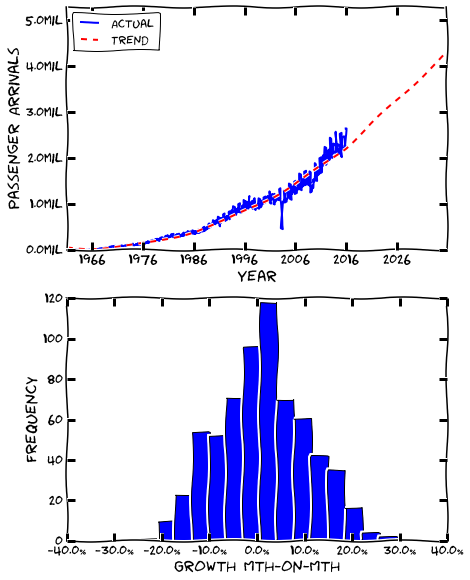

In [4]:
plt.xkcd()

# Setup variables
x = mdates.date2num(df.as_matrix(['month']).flatten())
y = df.as_matrix(['no_of_air_passenger_arrivals']).flatten()

# Use Polynomial fit
# Perhaps there is some inflection
z=np.polyfit(x,y,2)
p=np.poly1d(z)

# Predict Arrival at 2035 based on our polynomial fit
x2 = np.append(x,mdates.date2num(date_end))
y2 = p(x2)

# Format the Graph
fig = plt.figure(figsize=(15, 20))
ax = plt.subplot2grid((4,2), (0,0))
ax2 = plt.subplot2grid((4,2), (1,0))

ax.set_xlabel(("Year"),size=16)
ax.set_ylabel(("Passenger Arrivals"),size=16)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, tick: str(int(x)/1000000)+'mil'))
ax.set_ylim(0,df.as_matrix(['no_of_air_passenger_arrivals']).max()*2)

ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, tick: str(x*100)+'%'))
ax2.set_xlabel(("Growth Mth-on-Mth"),size=16)
ax2.set_xlim(-0.4,0.4)
ax2.set_ylabel(("Frequency"),size=16)

ax.plot_date(df['month'],df['no_of_air_passenger_arrivals'],fmt='-')
ax.plot(x2,y2,'r--')

ROC = df['no_of_air_passenger_arrivals'].pct_change(1)
ax2 = ROC.hist(bins=30,grid=False)

# Visualise the graph
ax.legend(['Actual', 'Trend' ],loc='upper left',fontsize=12)
plt.show()

In [5]:
import statistics

Pvar = statistics.pvariance(ROC[1:].as_matrix().flatten())
Pstd = statistics.pstdev(ROC[1:].as_matrix().flatten())

Svar = statistics.variance(ROC[1:].as_matrix().flatten())
Sstd = statistics.stdev(ROC[1:].as_matrix().flatten())

print("Growth rates sample Mean is %.4f \n Std Dev is %.4f, Variance is %.4f" %(ROC.mean()*100,Sstd*100,Svar*10000))
print("Growth rates est population Mean is %.4f \n Std Dev is %.4f ,Variance is %.4f"%(ROC.mean()*100,Pstd*100,Pvar*10000))


Growth rates sample Mean is 1.3157 
 Std Dev is 9.9579, Variance is 99.1602
Growth rates est population Mean is 1.3157 
 Std Dev is 9.9504 ,Variance is 99.0097


- We observe that the population of arrival passengers is growing exponentially
- The percentage growth month-on-month averages 1.32% with a Standard Deviation of -+ 9.9%

In [6]:
MOC = df['no_of_air_passenger_arrivals'] - df['no_of_air_passenger_arrivals'].shift(1)

Pvar = statistics.pvariance(MOC[1:].as_matrix().flatten())
Pstd = statistics.pstdev(MOC[1:].as_matrix().flatten())

Svar = statistics.variance(MOC[1:].as_matrix().flatten())
Sstd = statistics.stdev(MOC[1:].as_matrix().flatten())

print("Passenger Growth sample Mean is %i \n Std Dev is %i, Variance is %i" %(MOC.mean(),Sstd,Svar))
print("Passenger Growth est population Mean is %i \n Std Dev is %i ,Variance is %i"%(MOC.mean(),Pstd,Pvar))

Passenger Growth sample Mean is 3993 
 Std Dev is 88001, Variance is 7744292620
Passenger Growth est population Mean is 3993 
 Std Dev is 87934 ,Variance is 7732541038


- The month-on-month change averages to 3993 with a standard deviation of -+ 87934 passengers

In [7]:
# Use of percentage as basis stepwise populating our forecast timeseries forward
def simulate_arrivals_pct(start,listrandmultipler):
    total = int(start)
    simulation = []
    for rand in listrandmultipler:
        projection = total * (100+rand)/100
        simulation.append(int(projection))
        total = projection
    return simulation

# Use of absolute figures as basis stepwise populating our forecast timeseries forward
def simulate_arrivals_abs(start,listrandpassenger):
    total = int(start)
    simulation = []
    for rand in listrandpassenger:
        projection = total + rand
        simulation.append(int(projection))
        total = projection
    return simulation

- Based on the sample parameters from the past observations of monthly passenger arrivals, we make some simple assumptions about the set of all possible future growth scenarios 

## Sample our growth inputs from a *normal* distribution

- With the parameters mean = 3993 and Std Dev = 87934 from our sample population above

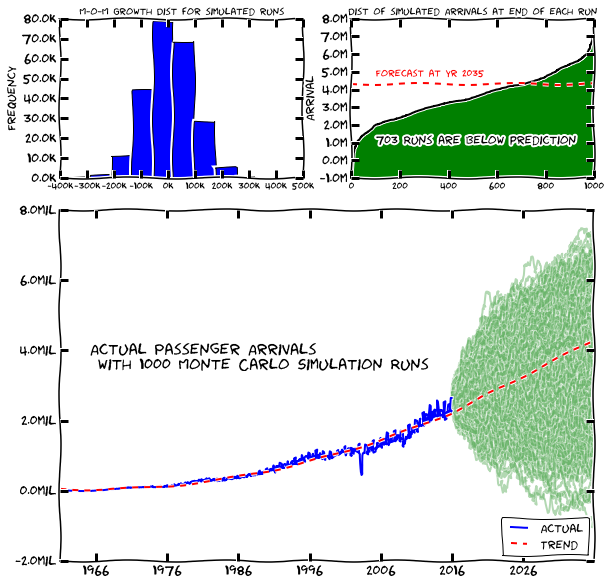

In [9]:
# Reset our data
collectlistOfForcast = []
collectlistOfRuns = []
collectlistOfNumbers = []
countbelow = 0
# For reproducibility
random.seed(seed)

for n in range(noofruns):
    listOfNumbers = []
    # Get random growth figures from specified distribution
    # Add dates to forecast ahead
    for x in range (0, mthrange):
        generatednumber = random.normalvariate(3993, 87934)
        listOfNumbers.append(generatednumber)
        collectlistOfNumbers.append(generatednumber)
    # Do the monte Carlo here
    listOfForcast=simulate_arrivals_abs(df['no_of_air_passenger_arrivals'].iloc[-1],listOfNumbers)
    # Check if the end of MC sim is below our projected figures
    if listOfForcast[-1] <= y2[-1]:
        countbelow += 1
    # Collect Data to be plotted later
    collectlistOfRuns.append(listOfForcast)
    collectlistOfForcast = np.append(collectlistOfForcast,int(listOfForcast[-1]))

#Plot our results
plotexpdata(df,mthrange,noofruns,collectlistOfForcast,collectlistOfRuns,collectlistOfNumbers,countbelow,pct=False)

In [10]:
print("Lower bound of our forcasted passengers/mth at %s is %.4f mil" %(date_end.year,collectlistOfForcast.min()/1000000))
print("Upper bound of our forcasted passengers/mth at %s is %.4f mil" %(date_end.year,collectlistOfForcast.max()/1000000))
print("Range of values is %.4f mil" %((collectlistOfForcast.max()-collectlistOfForcast.min())/1000000))


Lower bound of our forcasted passengers/mth at 2035 is -0.9337 mil
Upper bound of our forcasted passengers/mth at 2035 is 7.4435 mil
Range of values is 8.3772 mil


## Sample our growth inputs from a *triangular* distribution
- Observation from the normal disribution of abs growths rates above , we use upper/lower bound of +-200k with center 3993 as parameters for our triangular dist


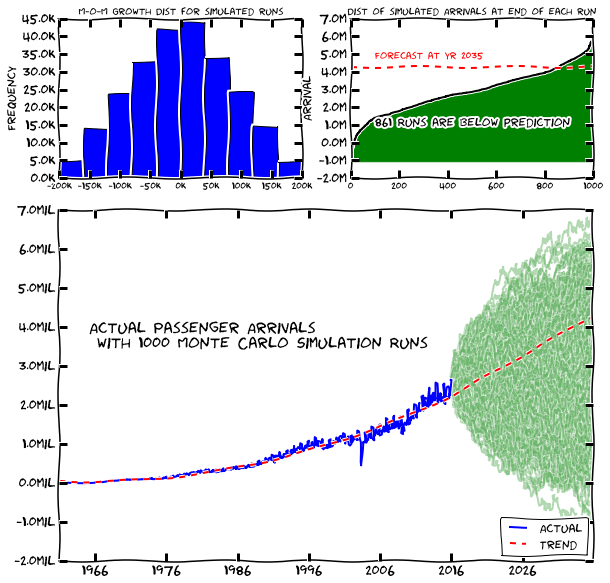

In [11]:
# Reset our data
collectlistOfForcast = []
collectlistOfRuns = []
collectlistOfNumbers = []
countbelow = 0
# For reproducibility
random.seed(seed)

for n in range(noofruns):
    listOfNumbers = []
    # Get random growth figures from specified distribution
    # Add dates to forecast ahead
    for x in range (0, mthrange):
        generatednumber = random.triangular(-200000,200000,3993)
        listOfNumbers.append(generatednumber)
        collectlistOfNumbers.append(generatednumber)
    # Do the monte Carlo here
    listOfForcast=simulate_arrivals_abs(df['no_of_air_passenger_arrivals'].iloc[-1],listOfNumbers)
    # Check if the end of MC sim is below our projected figures
    if listOfForcast[-1] <= y2[-1]:
        countbelow += 1
    # Collect Data to be plotted later
    collectlistOfRuns.append(listOfForcast)
    collectlistOfForcast = np.append(collectlistOfForcast,int(listOfForcast[-1]))

#Plot our results
plotexpdata(df,mthrange,noofruns,collectlistOfForcast,collectlistOfRuns,collectlistOfNumbers,countbelow,pct=False)

In [12]:
print("Lower bound of our forcasted passengers/mth at %s is %.4f mil" %(date_end.year,collectlistOfForcast.min()/1000000))
print("Upper bound of our forcasted passengers/mth at %s is %.4f mil" %(date_end.year,collectlistOfForcast.max()/1000000))
print("Range of values is %.4f mil" %((collectlistOfForcast.max()-collectlistOfForcast.min())/1000000))


Lower bound of our forcasted passengers/mth at 2035 is -1.0428 mil
Upper bound of our forcasted passengers/mth at 2035 is 6.9312 mil
Range of values is 7.9740 mil


## Sample our growth inputs from a *uniform* distribution
- Using similar +- 200k as parameters for our uniform distribution

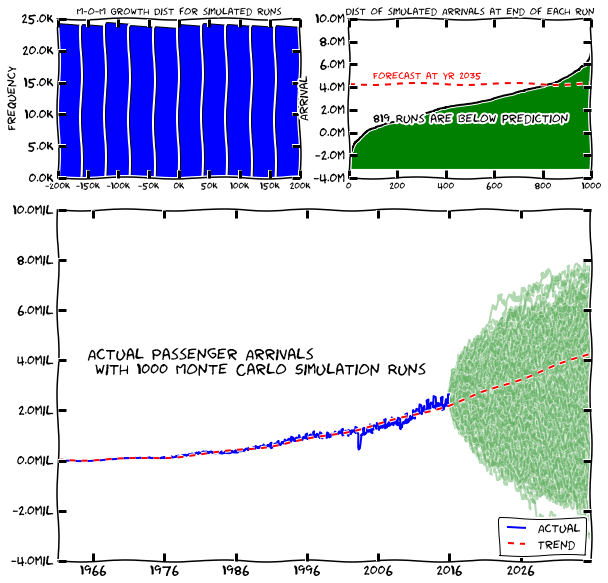

In [13]:
# Reset our data
collectlistOfForcast = []
collectlistOfRuns = []
collectlistOfNumbers = []
countbelow = 0
# For reproducibility
random.seed(seed)

for n in range(noofruns):
    listOfNumbers = []
    # Get random growth figures from specified distribution
    # Add dates to forecast ahead
    for x in range (0, mthrange):
        generatednumber = random.uniform(-200000,200000)
        listOfNumbers.append(generatednumber)
        collectlistOfNumbers.append(generatednumber)
    # Do the monte Carlo here
    listOfForcast=simulate_arrivals_abs(df['no_of_air_passenger_arrivals'].iloc[-1],listOfNumbers)
    # Check if the end of MC sim is below our projected figures
    if listOfForcast[-1] <= y2[-1]:
        countbelow += 1
    # Collect Data to be plotted later
    collectlistOfRuns.append(listOfForcast)
    collectlistOfForcast = np.append(collectlistOfForcast,int(listOfForcast[-1]))

#Plot our results
plotexpdata(df,mthrange,noofruns,collectlistOfForcast,collectlistOfRuns,collectlistOfNumbers,countbelow,pct=False)

In [14]:
print("Lower bound of our forcasted passengers/mth at %s is %.4f mil" %(date_end.year,collectlistOfForcast.min()/1000000))
print("Upper bound of our forcasted passengers/mth at %s is %.4f mil" %(date_end.year,collectlistOfForcast.max()/1000000))
print("Range of values is %.4f mil" %((collectlistOfForcast.max()-collectlistOfForcast.min())/1000000))


Lower bound of our forcasted passengers/mth at 2035 is -3.0960 mil
Upper bound of our forcasted passengers/mth at 2035 is 8.0702 mil
Range of values is 11.1662 mil


Prophet: Automatic Forecasting Procedure
========================================

Prophet is a procedure for forecasting time series data.  It is based on an additive model where non-linear trends are fit with yearly and weekly seasonality, plus holidays.  It works best with daily periodicity data with at least one year of historical data.  Prophet is robust to missing data, shifts in the trend, and large outliers.

Prophet is open source software released by Facebook's Core Data Science team.

Full documentation and examples available at the homepage:

https://facebookincubator.github.io/prophet/

In [15]:
from fbprophet import Prophet

fbtest = pulldatagov(datauid)
# Format to Prophet's inputs ds , y
fbtest.rename(index=str, columns={"month": "ds", "no_of_air_passenger_arrivals": "y"},inplace=True)
fbtest.head()

,ds,y
_id,,
1,1961-01-01,11814
2,1961-02-01,11027
3,1961-03-01,12703
4,1961-04-01,13159
5,1961-05-01,12221


In [16]:
m = Prophet(yearly_seasonality=False,weekly_seasonality=False)
m.fit(fbtest);

# Make Monthly Forcast

future = m.make_future_dataframe(periods=mthrange,freq='M')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
895,2035-08-31,4460387.801792,4097527.012883,4868463.361196
896,2035-09-30,4469106.892066,4110850.289404,4849132.477056
897,2035-10-31,4478116.618682,4123542.529965,4864027.260513
898,2035-11-30,4486835.708955,4129003.603249,4893810.047504
899,2035-12-31,4495845.435571,4129818.321374,4901824.529150


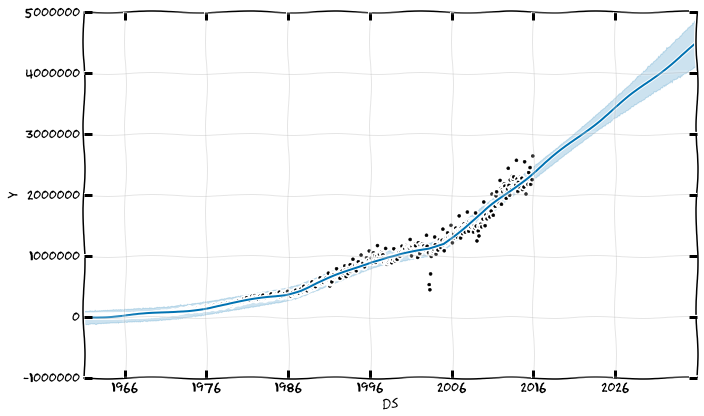

In [20]:
m.plot(forecast);

In [21]:
print("Lower bound of our forcasted passengers/mth at %s is %.4f mil" %(date_end.year,forecast['yhat_lower'].iloc[-1]/1000000))
print("Upper bound of our forcasted passengers/mth at %s is %.4f mil" %(date_end.year,forecast['yhat_upper'].iloc[-1]/1000000))
print("Range of values is %.4f mil" %((forecast['yhat_upper'].iloc[-1]-forecast['yhat_lower'].iloc[-1])/1000000))

Lower bound of our forcasted passengers/mth at 2035 is 4.1298 mil
Upper bound of our forcasted passengers/mth at 2035 is 4.9018 mil
Range of values is 0.7720 mil


--------

# Notes

1. Looking at the monte carlo results of course it does not make sense for the no. of arrival passengers to be negative, below zero. On a side note, data on departure passengers is tracked separately by the Civil Aviation Authority of Singapore. 
2. Passenger arrivals are  a function of air vehicle and terminal capacity as well as airport attractiveness / connectivity, this is not explored in this experiment.
3. From the various shapes of the random distributions in our monte carlo exercises above, it shown that the polynomial projections of historial data tend to over-estimate the future, the spread of predictions of all simulations are similar.
4. As a comparision, Facebooks' Prophet predicts Changi's Arrival Passengers in the range of ** 4-5 million ** per mth in year 2035 based on past observations.
5. The tighter confidence interval range for Prophet's forecast indicates algorithm has more certainty than running monte carlo simulations.
6. Check any interesting trends in the log transformation of passengers arrivals.

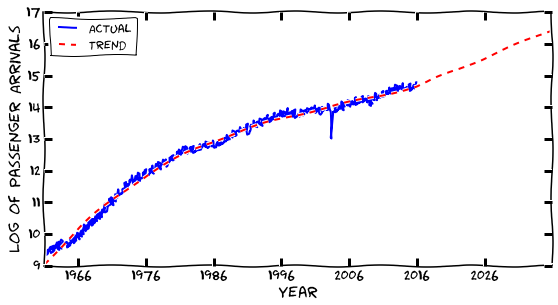

In [22]:
# Do Log transform
df = pulldatagov(datauid)
df['no_of_air_passenger_arrivals']=np.log(df['no_of_air_passenger_arrivals'])

x = mdates.date2num(df.as_matrix(['month']).flatten())
y = df.as_matrix(['no_of_air_passenger_arrivals']).flatten()
z=np.polyfit(x,y,3)
p=np.poly1d(z)
x2 = np.append(x,mdates.date2num(date_end))
y2 = p(x2)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(221)
ax.set_xlabel(("Year"),size=16)
ax.set_ylabel(("Log of Passenger Arrivals"),size=16)
ax.plot_date(df['month'],df['no_of_air_passenger_arrivals'],fmt='-')
ax.plot(x2,y2,'r--')
ax.legend(['Actual', 'Trend' ],loc='upper left',fontsize=12)
plt.show()